In [1]:
import os

os.chdir("../../")

import statsmodels.tsa.api as smt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=2.0, style="whitegrid")

In [2]:
ts_data = ingestion.read_combined()

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Train and test set

In [3]:
ts_data = ts_data.dropna(subset=["temperature_capped", "consumption"])
X = ts_data[["temperature_capped", "weekend"]]
y = ts_data["consumption"]

X_train = X[:"2020"]
X_test = X["2021":]
y_train = y[:"2020"]
y_test = y["2021":]

# AutoReg with lag 1 and external regressors
model = smt.AutoReg(y_train, lags=[1, 45], exog=X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:              consumption   No. Observations:                 1553
Model:             Restr. AutoReg-X(45)   Log Likelihood              -19959.048
Method:                 Conditional MLE   S.D. of innovations         135469.855
Date:                  Sat, 13 May 2023   AIC                          39930.096
Time:                          18:38:32   BIC                          39962.007
Sample:                      11-15-2016   HQIC                         39941.981
                           - 12-31-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.098e+06   4.19e+04     50.076      0.000    2.02e+06    2.18e+06
consumption.L1         0.5467      0.009     57.785      0.000       0.528       0.565
consumption.L45       -0.0216      0.004     -5.413      0.000      -0.029      -0.014
temperature_capped -7.798e+04   1599.304    -48.762      0.000   -8.11e+04   -7.49e+04
weekend            -2.418e+05   7859.313    -30.771      0.000   -2.57e+05   -2.26e+05
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0656           -0.0723j            1.0681           -0.0108
AR.2             1.0656           +0.0723j            1.0681            0.0108
AR.3             1.0474           -0.2161j            1.0694           -0.0324
AR.4             1.0474           +0.2161j            1.0694            0.0324
AR.5             1.0104           -0.3573j            1.0717           -0.0541
AR.6             1.0104           +0.3573j            1.0717            0.0541
AR.7             0.9544           -0.4936j            1.0745           -0.0760
AR.8             0.9544           +0.4936j            1.0745            0.0760
AR.9             0.8798           -0.6220j            1.0774           -0.0979
AR.10            0.8798           +0.6220j            1.0774            0.0979
AR.11            0.7873           -0.7397j            1.0803           -0.1200
AR.12            0.7873           +0.7397j            1.0803            0.1200
AR.13            0.6786           -0.8439j            1.0829           -0.1422
AR.14            0.6786           +0.8439j            1.0829            0.1422
AR.15            0.5558           -0.9322j            1.0854           -0.1644
AR.16            0.5558           +0.9322j            1.0854            0.1644
AR.17            0.4212           -1.0027j            1.0875           -0.1867
AR.18            0.4212           +1.0027j            1.0875            0.1867
AR.19            0.2776           -1.0536j            1.0895           -0.2090
AR.20            0.2776           +1.0536j            1.0895            0.2090
AR.21            0.1277           -1.0838j            1.0913           -0.2313
AR.22            0.1277           +1.0838j            1.0913            0.2313
AR.23           -0.0252           -1.0926j            1.0929           -0.2537
AR.24           -0.0252           +1.0926j            1.0929            0.2537
AR.25           -0.1782           -1.0796j            1.0943           -0.2760
AR.26           -0.1782           +1.0796j            1.0943            0.2760
AR.27           -0.3281           -1.0452j            1.0955           -0.2984
AR.28           -0.3281           +1.0452j            1.0955            0.2984

In [4]:
predictions = results.get_prediction(start=0, end="2022-11-28", exog=X_train, exog_oos=X_test)
predictions_cofindence_intervals = predictions.conf_int()

modelled_consumption = predictions.predicted_mean

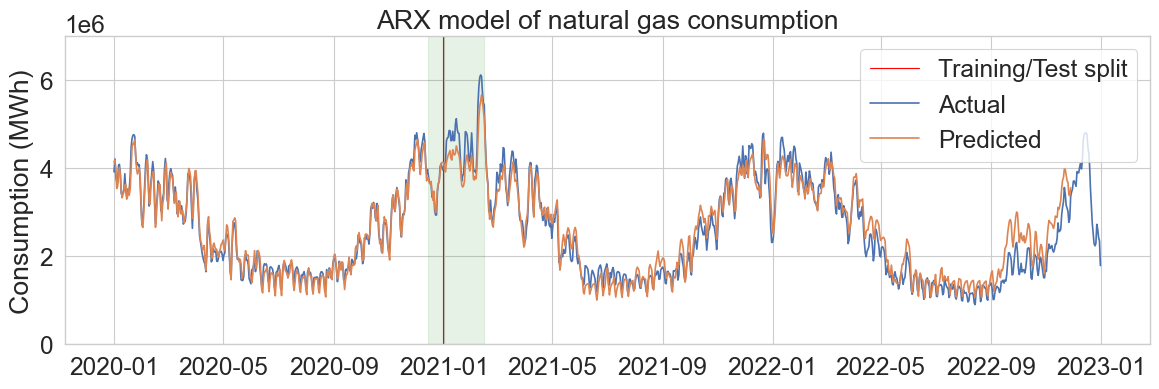

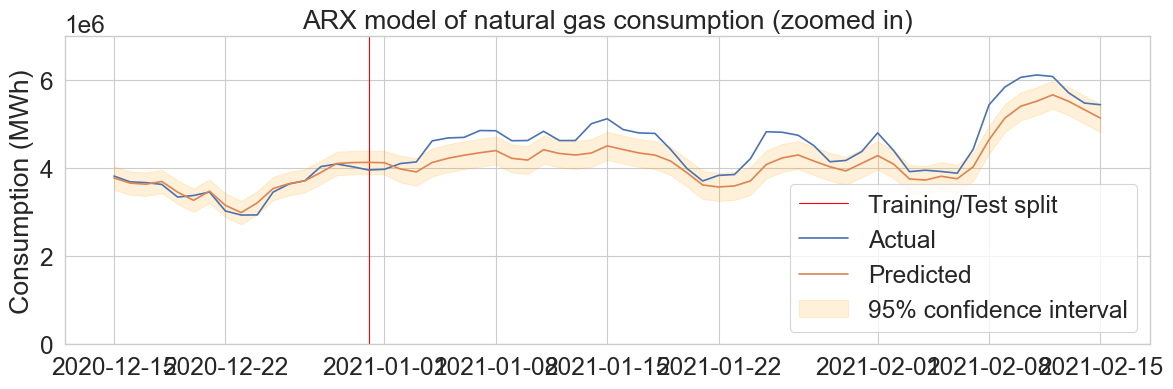

In [5]:
# Plot 1 - multiple years
fig, ax = plt.subplots(figsize=(14, 4))

ax.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax.axvspan(
    pd.Timestamp("2020-12-15"), pd.Timestamp("2021-02-15"), color="green", alpha=0.1
)
ax.plot(y["2020":], label="Actual")
ax.plot(modelled_consumption["2020":], label="Predicted")
ax.set_ylabel("Consumption (MWh)")
ax.legend()
ax.set_title("ARX model of natural gas consumption")
ax.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_011_001.svg", format="svg", bbox_inches="tight")

# Plot 2 - zoomed in
fig, ax2 = plt.subplots(figsize=(14, 4))

ax2.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax2.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax2.plot(modelled_consumption["2020-12-15":"2021-02-15"], label="Predicted")
ax2.fill_between(
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0].index,
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0],
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 1],
    color="orange",
    alpha=0.15,
    label="95% confidence interval",
)
ax2.set_ylabel("Consumption (MWh)")
ax2.legend()
ax2.set_title("ARX model of natural gas consumption (zoomed in)")
ax2.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_011_002.svg", format="svg", bbox_inches="tight")

In [6]:
# Mean Absolute Percentage Error (MAPE) for 60days after training data cutoff
mape_14d = (
    abs(y["2021-01-01":"2021-01-14"] - modelled_consumption["2021-01-01":"2021-01-14"])
    / y["2021-01-01":"2021-01-14"]
).mean() * 100

mape_60d = (
    abs(y["2021-01-01":"2021-02-28"] - modelled_consumption["2021-01-01":"2021-02-28"])
    / y["2021-01-01":"2021-02-28"]
).mean() * 100

mape_365d = (
    abs(y["2021-01-01":"2022-01-01"] - modelled_consumption["2021-01-01":"2022-01-01"])
    / y["2021-01-01":"2022-01-01"]
).mean() * 100


print(f"MAPE : {mape_14d:.2f}% for 14 days")
print(f"MAPE : {mape_60d:.2f}% for 60 days")
print(f"MAPE : {mape_365d:.2f}% for 365 days")

MAPE : 8.19% for 14 days
MAPE : 6.94% for 60 days
MAPE : 8.43% for 365 days
